# Paper 2: The Unreasonable Effectiveness of Recurrent Neural Networks
## Andrej Karpathy

### Character-Level Language Model with Vanilla RNN

Implementation of a character-level RNN that learns to generate text.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)

## Generate Synthetic Training Data

In [2]:
# Simple synthetic text with patterns
data = """
hello world
hello deep learning
deep neural networks
neural networks learn patterns
patterns in data
data drives learning
learning from examples
examples help networks
networks process information
information is everywhere
everywhere you look data
""" * 10  # Repeat for more training data

# Build vocabulary
chars = sorted(list(set(data)))
vocab_size = len(chars)
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Data length: {len(data)} characters")
print(f"Vocabulary size: {vocab_size}")
print(f"Vocabulary: {repr(''.join(chars))}")

Data length: 2490 characters
Vocabulary size: 24
Vocabulary: '\n acdefghiklmnoprstuvwxy'


## Vanilla RNN Implementation

In [3]:
class VanillaRNN:
    def __init__(self, vocab_size, hidden_size):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
    def forward(self, inputs, hprev):
        """
        inputs: list of integers (character indices)
        hprev: initial hidden state
        """
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        
        # Forward pass
        for t, char_idx in enumerate(inputs):
            # One-hot encode input
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][char_idx] = 1
            
            # Hidden state: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
            hs[t] = np.tanh(
                np.dot(self.Wxh, xs[t]) + 
                np.dot(self.Whh, hs[t-1]) + 
                self.bh
            )
            
            # Output: y_t = W_hy * h_t + b_y
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            
            # Softmax probabilities
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
            
        return xs, hs, ys, ps
    
    def loss(self, ps, targets):
        """Cross-entropy loss"""
        loss = 0
        for t, target_idx in enumerate(targets):
            loss += -np.log(ps[t][target_idx, 0])
        return loss
    
    def backward(self, xs, hs, ps, targets):
        """Backpropagation through time"""
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        
        # Backward pass
        for t in reversed(range(len(targets))):
            # Output gradient
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1
            
            # Output layer gradients
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            
            # Hidden layer gradient
            dh = np.dot(self.Why.T, dy) + dhnext
            dhraw = (1 - hs[t] ** 2) * dh  # tanh derivative
            
            # Weight gradients
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            
            # Gradient for next timestep
            dhnext = np.dot(self.Whh.T, dhraw)
        
        # Clip gradients to prevent exploding gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
        
        return dWxh, dWhh, dWhy, dbh, dby
    
    def sample(self, h, seed_ix, n):
        """
        Sample a sequence of characters from the model
        h: initial hidden state
        seed_ix: seed character index
        n: number of characters to generate
        """
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        indices = []
        
        for t in range(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            
            # Sample from distribution
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            indices.append(ix)
        
        return indices

# Initialize model
hidden_size = 64
rnn = VanillaRNN(vocab_size, hidden_size)
print(f"\nModel initialized with {hidden_size} hidden units")


Model initialized with 64 hidden units


## Training Loop

In [4]:
def train_rnn(rnn, data, char_to_ix, ix_to_char, num_iterations=2000, seq_length=25):
    """Train the RNN"""
    n = 0  # Position in data
    p = 0  # Data pointer
    
    # Memory variables for Adagrad
    mWxh = np.zeros_like(rnn.Wxh)
    mWhh = np.zeros_like(rnn.Whh)
    mWhy = np.zeros_like(rnn.Why)
    mbh = np.zeros_like(rnn.bh)
    mby = np.zeros_like(rnn.by)
    
    smooth_loss = -np.log(1.0 / vocab_size) * seq_length
    losses = []
    
    hprev = np.zeros((hidden_size, 1))
    
    for n in range(num_iterations):
        # Prepare inputs and targets
        if p + seq_length + 1 >= len(data) or n == 0:
            hprev = np.zeros((hidden_size, 1))
            p = 0
        
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
        
        # Forward pass
        xs, hs, ys, ps = rnn.forward(inputs, hprev)
        loss = rnn.loss(ps, targets)
        
        # Backward pass
        dWxh, dWhh, dWhy, dbh, dby = rnn.backward(xs, hs, ps, targets)
        
        # Adagrad parameter update
        learning_rate = 0.1
        for param, dparam, mem in zip(
            [rnn.Wxh, rnn.Whh, rnn.Why, rnn.bh, rnn.by],
            [dWxh, dWhh, dWhy, dbh, dby],
            [mWxh, mWhh, mWhy, mbh, mby]
        ):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)
        
        # Track loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        
        # Sample from model
        if n % 200 == 0:
            sample_ix = rnn.sample(hprev, inputs[0], 100)
            txt = ''.join(ix_to_char[ix] for ix in sample_ix)
            print(f"\n--- Iteration {n}, Loss: {smooth_loss:.4f} ---")
            print(txt)
        
        # Move data pointer
        p += seq_length
        hprev = hs[len(inputs) - 1]
    
    return losses

# Train the model
print("Training RNN...\n")
losses = train_rnn(rnn, data, char_to_ix, ix_to_char, num_iterations=2000)

Training RNN...


--- Iteration 0, Loss: 79.4513 ---
lvfaxhnugscfcuerxmmkgloyxvwlpwiyiorxesmftnpgloidxlsihiimmlcldcxopiwothxuvdeffv
 fdeun
kiaprss
xuw
xu

--- Iteration 200, Loss: 78.4069 ---
s
nworvernt ksrntwam epura nkctwnwhorauerl
ars nositin e necrekaraknllo
ecdamermogdl arwo
rorseaknin

--- Iteration 400, Loss: 72.8862 ---
twosr hernp
eta dao ierlis
pelevelerns neetyorn ns
yrwota n dto nins deorsg naata inrn
gomeutadatyes

--- Iteration 600, Loss: 65.6525 ---
l arn
lele depao lo farinfrnioxning nerek
le
p
daes
rneorn examples
letworl neurpss in dleur
earn
in

--- Iteration 800, Loss: 58.1478 ---
ormatearss kateale neamples peatwovelp neern in eereg
hp psas deterks inforng
datetwherecetworminfor

--- Iteration 1000, Loss: 51.1088 ---
ello d
ea works leo yorns learnfora deata
p farns
leurel es innes nen eramateol neu erl norks
leurks

--- Iteration 1200, Loss: 44.6787 ---
s learn netw
heles
everkllorninpas data nes
in
depaes dtacerlinxatp
rvernss nerks lrarnforminfohe  e

--- Itera

## Visualize Training Progress

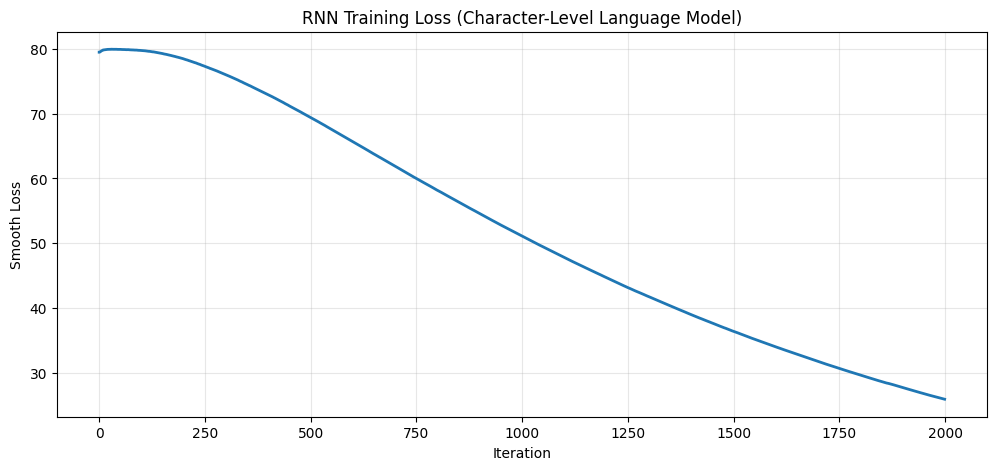

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Smooth Loss')
plt.title('RNN Training Loss (Character-Level Language Model)')
plt.grid(True, alpha=0.3)
plt.show()

## Generate Text from Trained Model

In [6]:
# Generate samples with different seeds
h = np.zeros((hidden_size, 1))

print("Generated samples:\n")
for i in range(5):
    seed_char = np.random.choice(chars)
    seed_ix = char_to_ix[seed_char]
    sample_ix = rnn.sample(h, seed_ix, 150)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print(f"Sample {i+1} (seed: '{seed_char}'):")
    print(txt)
    print()

Generated samples:

Sample 1 (seed: 'n'):
o d
ere erks nearn
irks p
ptt
oryhere
everywherlworvevele hep is itworis hel leromos looknin deg
lollouris exaverxnning xve matatwores
learns
in data 

Sample 2 (seed: 'h'):
elp
in
deep neurarning
heprawheplin oo  nete

eteywherlwovels
patarks
networu data
data 
hello wherloon in everywherpa
ivimplorns ining from promas de

Sample 3 (seed: 'h'):
elp tegirywherewhere
everywhererywhrexamples learninf
eryern
ears
detwerhesp iurins networmks
arom frompap detworks
networks racetforks lear
where
eve

Sample 4 (seed: 'v'):
eleurep learn patain
patternss ivives elpa
patiorning
from examples leo lerns networks
networks paattworlo dremplelworca
faram exemello work
hele dout

Sample 5 (seed: 'x'):
amamat
evern drou
learn herin help networks hepatworld
hele doaran pattwhrep
arocdsis ikg
ing
paaa daeiylwramatterns neuram p ordning
heryworks nearni



## Visualize Hidden State Activations

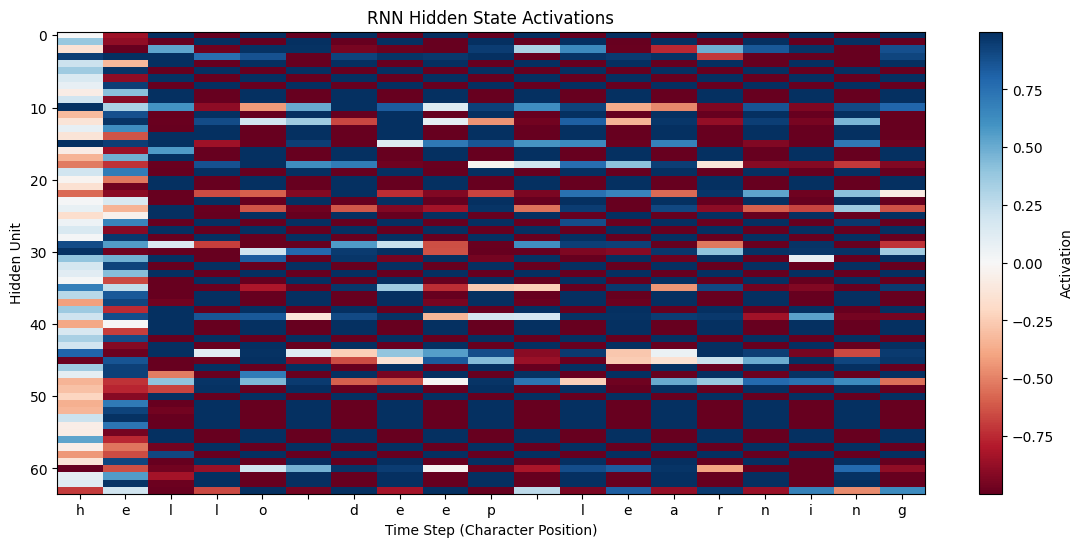


Visualization shows how hidden states evolve as RNN processes 'hello deep learning'


In [7]:
# Forward pass through a sequence to visualize activations
test_text = "hello deep learning"
test_inputs = [char_to_ix[ch] for ch in test_text]
hprev = np.zeros((hidden_size, 1))

xs, hs, ys, ps = rnn.forward(test_inputs, hprev)

# Extract hidden states
hidden_states = np.array([hs[t].flatten() for t in range(len(test_inputs))])

plt.figure(figsize=(14, 6))
plt.imshow(hidden_states.T, cmap='RdBu', aspect='auto', interpolation='nearest')
plt.colorbar(label='Activation')
plt.xlabel('Time Step (Character Position)')
plt.ylabel('Hidden Unit')
plt.title('RNN Hidden State Activations')
plt.xticks(range(len(test_text)), list(test_text))
plt.show()

print(f"\nVisualization shows how hidden states evolve as RNN processes '{test_text}'")

## Key Takeaways

1. **Character-Level Modeling**: RNNs can learn to generate text character-by-character
2. **Recurrent Connections**: Hidden state carries information across time steps
3. **Backpropagation Through Time**: Gradients flow backwards through sequences
4. **Gradient Clipping**: Essential to prevent exploding gradients
5. **Sampling**: Temperature control in sampling affects diversity

### The Unreasonable Effectiveness:
- Simple RNN architecture can learn complex patterns
- No explicit feature engineering needed
- Learns hierarchical representations automatically
- Generalizes to unseen character combinations